In [112]:
import sklearn
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
from catboost import CatBoostRegressor, monoforest

from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

from tqdm.notebook import tqdm

In [8]:
RANDOM_STATE = 239

In [11]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (10, 10)

In [20]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

## Dataset generation

In [16]:
X, y = make_regression(n_samples=2000, n_features=50, n_informative=30, noise=1., random_state=RANDOM_STATE)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.4)

In [18]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=RANDOM_STATE, test_size=0.5)

## Sklearn GBR training

In [21]:
def train_gradient_boosting_regressor(X_train, y_train, random_state=RANDOM_STATE, arguments_grid=None):
    arguments_grid = arguments_grid if arguments_grid is not None else {
        'n_estimators' : range(100, 1001, 200),
        'max_depth': range(2, 9),
        'learning_rate' : np.hstack([np.arange(0.001, 0.01, 0.002), 
                                     np.arange(0.01, 0.1, 0.02), 
                                     np.arange(0.1, 1., 0.2)])
    }
    reg = GradientBoostingRegressor(random_state=random_state)
    grid_reg = GridSearchCV(reg, arguments_grid, verbose=5, cv=5, n_jobs=4)
    grid_reg.fit(X_train, y_train)
    print(f'Best inital arguments set: {grid_reg.best_params_}')
    return grid_reg.best_params_

In [23]:
best_initial_params = train_gradient_boosting_regressor(X_train, y_train)

Fitting 5 folds for each of 525 candidates, totalling 2625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   10.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  9.4min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 17.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 27.5min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 35.7min
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed: 46.2min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed: 56.3min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed: 69.8min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 84.9min
[Parallel(n_jobs=4)]: Done 2170 tasks      | elapsed: 101.3min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed: 114.7min
[Parallel(n_jobs=4)]: Done 2625 out of 2625 | elapsed: 115.8min finished


Best inital arguments set: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 900}


In [4]:
with open('tmp_dataset.pkl', 'rb') as input_file:
    X_train, X_test, X_val, y_train, y_test, y_val, best_initial_params = pickle.load(input_file)

In [21]:
def print_results(reg, X_train, X_val, X_test, y_train, y_val, y_test):
    for X_, y_, label  in [(X_train, y_train, 'Train'), (X_val, y_val, 'Val'), (X_test, y_test, 'Test')]:
        print(f'{label} scores:')
        print(f'R2: {reg.score(X_, y_)}')
        print(f'RMSE: {rmse(y_, reg.predict(X_))}')

In [26]:
def build_plot(x, ys, label_x='', label_y='', title=''):
    plt.clf()
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(title)
    for y_label, y in ys.items():
        plt.plot(x, y, label=y_label)
    plt.legend()
    plt.show()

In [36]:
def get_scores_for_param_range(model, params, param, param_range, X_train, X_val, y_train, y_val):
    train_scores = []
    test_scores = []
    for param_value in tqdm(param_range):
        current_params = params.copy()
        current_params[param] = param_value
        reg = model(**current_params).fit(X_train, y_train)
        train_scores.append(rmse(y_train, reg.predict(X_train)))
        test_scores.append(rmse(y_val, reg.predict(X_val)))
    return train_scores, test_scores

In [43]:
def select_best_param_value_from_range(model, current_params, param, param_title, param_range, X_train, X_val,
                                       y_train, y_val):
    train_scores, test_scores = get_scores_for_param_range(model, current_params, param, param_range,
                                                           X_train, X_val, y_train, y_val)
    build_plot(param_range, {'Train rmse' : train_scores, 'Val rmse' : test_scores},
               param_title, 'R2 score', f'Rmse score for different \'{param_title}\' values')
    best_param_value = param_range[np.argmin(test_scores)]
    if best_param_value != current_params[param]:
        print(f'Changing \'{param_title}\': {current_params[param]} -> {best_param_value}')
        best_params[param] = best_param_value
    return current_params

In [38]:
inital_reg = GradientBoostingRegressor(**best_initial_params).fit(X_train, y_train)

In [39]:
print_results(inital_reg, X_train, X_val, X_test, y_train, y_val, y_test)

Train scores:
R2: 0.9971678940428335
RMSE: 17.25053487832687
Val scores:
R2: 0.8915569962543214
RMSE: 103.49150551042561
Test scores:
R2: 0.88840347218239
RMSE: 101.54242793742067


In [40]:
best_params = best_initial_params.copy()

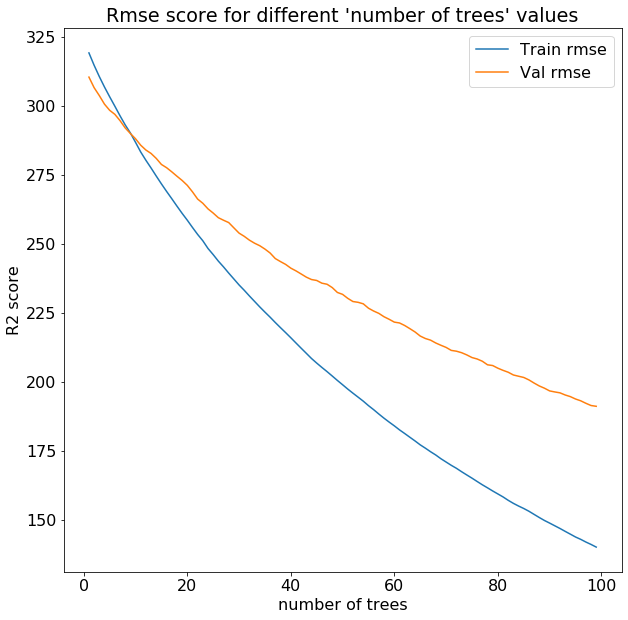

Changing 'number of trees': 3 -> 99


In [46]:
best_params = select_best_param_value_from_range(GradientBoostingRegressor, best_params, 'n_estimators',
                                                 'number of trees', np.arange(1, 100, 1), X_train, X_val,
                                                 y_train, y_val)

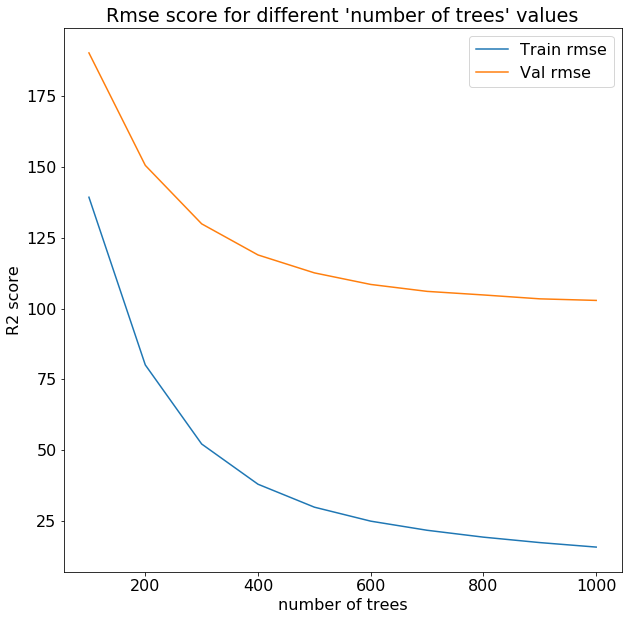

Changing 'number of trees': 99 -> 1000


In [47]:
best_params = select_best_param_value_from_range(GradientBoostingRegressor, best_params, 'n_estimators',
                                                 'number of trees', np.arange(100, 1001, 100), X_train, X_val,
                                                 y_train, y_val)

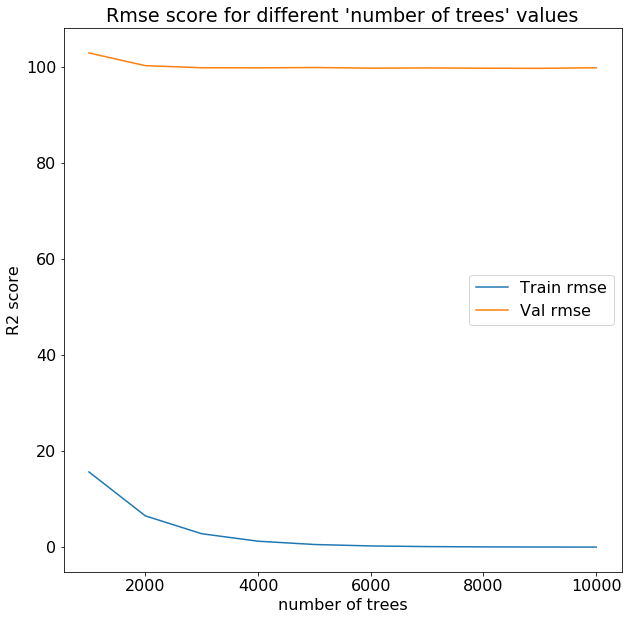

Changing 'number of trees': 1000 -> 9000


In [48]:
best_params = select_best_param_value_from_range(GradientBoostingRegressor, best_params, 'n_estimators',
                                                 'number of trees', np.arange(1000, 10001, 1000), X_train, X_val,
                                                 y_train, y_val)

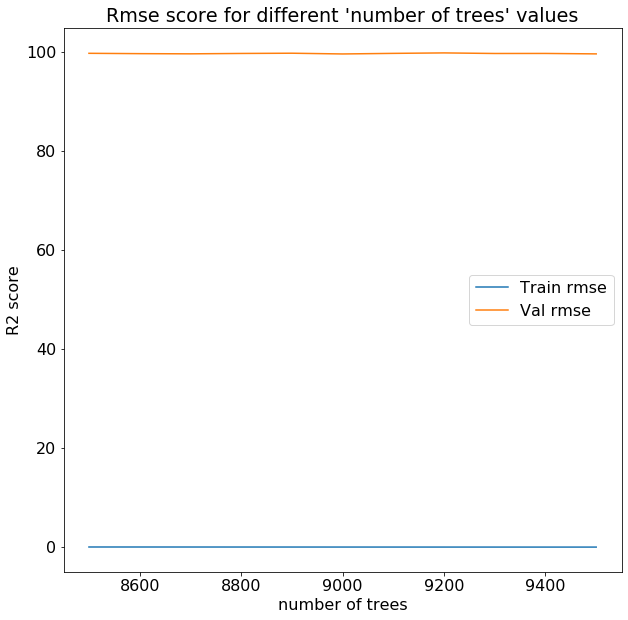

In [49]:
best_params = select_best_param_value_from_range(GradientBoostingRegressor, best_params, 'n_estimators',
                                                 'number of trees', np.arange(8500, 9501, 100), X_train, X_val,
                                                 y_train, y_val)

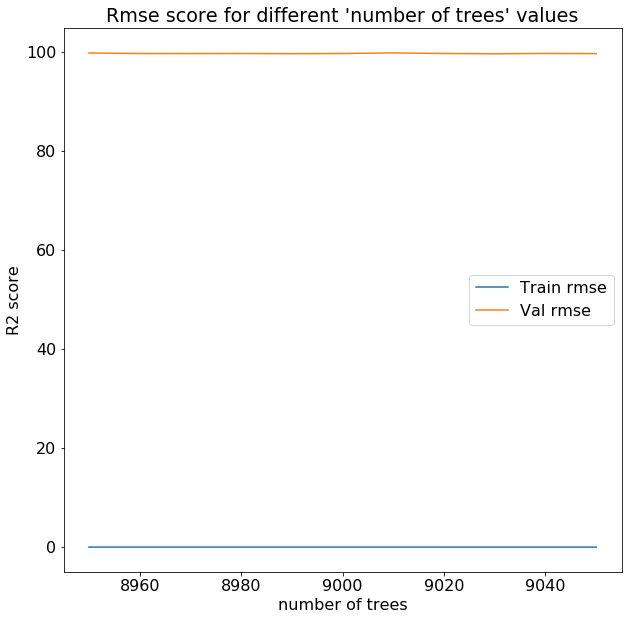

Changing 'number of trees': 9000 -> 9030


In [50]:
best_params = select_best_param_value_from_range(GradientBoostingRegressor, best_params, 'n_estimators',
                                                 'number of trees', np.arange(8950, 9051, 10), X_train, X_val,
                                                 y_train, y_val)

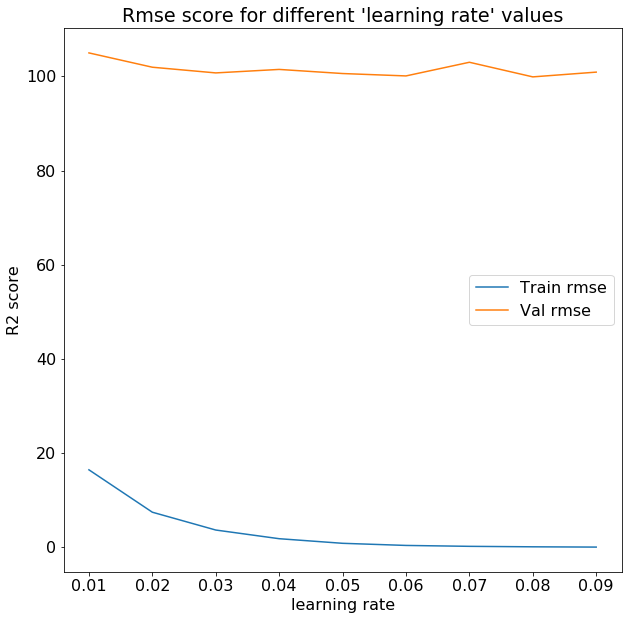

Changing 'learning rate': 0.1 -> 0.08


In [52]:
best_params = select_best_param_value_from_range(GradientBoostingRegressor, best_params, 'learning_rate',
                                                 'learning rate', np.arange(0.01, 0.1, 0.01), X_train, X_val,
                                                 y_train, y_val)

In [56]:
reg = GradientBoostingRegressor(**best_params).fit(X_train, y_train)

In [57]:
print_results(reg, X_train, X_val, X_test, y_train, y_val, y_test)

Train scores:
R2: 0.9999998760920802
RMSE: 0.11410307535339845
Val scores:
R2: 0.8990594431236414
RMSE: 99.8474053400947
Test scores:
R2: 0.8989722449999201
RMSE: 96.61455401514561


## Extract sklearn monomials

In [58]:
class Monomial:
    def __init__(self):
        self.features_splits = {}
        self.features = None
        self.thresholds = None

    def add_split(self, split_feature, split_value):
        if split_feature in self.features_splits:
            self.features_splits[split_feature] = max(self.features_splits[split_feature], split_value)
        else:
            self.features_splits[split_feature] = split_value

    def __eq__(self, other):
        if set(self.features_splits.keys()) != set(other.features_splits.keys()):
            return False
        for feature, threshold in self.features_splits.items():
            if not np.isclose(threshold, other.features_splits[feature]):
                return False
        return True

    def finalize(self):
        feature_items = list(self.features_splits.items())
        self.features = np.array([feature_item[0] for feature_item in feature_items], dtype=np.int)
        self.thresholds = np.array([feature_item[1] for feature_item in feature_items])

    def __call__(self, x):
        if self.features is None:
            self.finalize()
        x = np.array(x)
        return 1 if np.all(np.less_equal(self.thresholds, x[self.features])) else 0
    
    def print_to_console(self):
        if len(self.features_splits) == 0:
            print(1, end='')
        for feature, threshold in self.features_splits.items():
            print(f'[x[{feature}] >= {threshold}]', end='')
        print()

In [59]:
class TreeNode:
    def __init__(self, parent=None, is_left_son=None, feature=None, threshold=None):
        self.parent = parent
        self.is_left_son = is_left_son
        self.feature = feature
        self.threshold = threshold

In [60]:
def parse_decision_tree(estimator):
    tree = estimator[0].tree_
    n = len(tree.children_left)
    assert n > 0
    nodes = [TreeNode() for _ in range(n)]
    for i in range(n):
        if tree.children_left[i] != tree.children_right[i]:
            nodes[tree.children_left[i]].parent = i
            nodes[tree.children_left[i]].is_left_son = True
            nodes[tree.children_right[i]].parent = i
            nodes[tree.children_right[i]].is_left_son = False
            nodes[i].feature = tree.feature[i]
            nodes[i].threshold = tree.threshold[i]
    return nodes

def generate_monimals(splits):
    # left sons are optional
    optional_splits = []
    mandatory_splits = []
    for feature, threshold, is_left_son in splits:
        if is_left_son:
            optional_splits.append((feature, threshold))
        else:
            mandatory_splits.append((feature, threshold))
    m = len(optional_splits)
    monomials = []
    for mask in range(2 ** m):
        monomials.append(Monomial())
        for mandatory_split in mandatory_splits:
            monomials[-1].add_split(*mandatory_split)
        for i in range(m):
            if (2 ** i) & mask:
                monomials[-1].add_split(*optional_splits[i])
        monomials[-1].finalize()
    return monomials

def sift_monomials(monomials):
    # Removes duplicates from monomials (we need it since Monomial isn't hashable)
    result = []
    for monimial in monomials:
        if monimial not in result:
            result.append(monimial)
    return result

def parse_tree_monomials(tree_estimator):
    nodes = parse_decision_tree(tree_estimator)
    monomials = []
    for node in nodes:
        if node.feature is not None:
            continue
        splits = []
        while node.parent is not None:
            is_left_son = node.is_left_son
            node = nodes[node.parent]
            splits.append((node.feature, node.threshold, is_left_son))
        monomials.extend(generate_monimals(splits))
    return sift_monomials(monomials)

def parse_ensemble_monomials(tree_ensemble):
    monomials = []
    for estimator in tqdm(tree_ensemble):
        for monomial in parse_tree_monomials(estimator):
            if monomial not in monomials:
                monomials.append(monomial)
    return monomials

In [63]:
monomials = parse_ensemble_monomials(reg)

## Training Lasso

In [67]:
def transform_X(X, monomials):
    result = np.zeros((X.shape[0], len(monomials)), dtype=np.bool)
    for i, x in enumerate(tqdm(X)):
        for j, m in enumerate(monomials):
            result[i, j] = m(x)
    return result

In [70]:
X_train_monomial = transform_X(X_train, monomials)
X_val_monomial = transform_X(X_val, monomials)
X_test_monomial = transform_X(X_test, monomials)

In [98]:
def train_lasso(n_iterations, lambda_arg, X, y):
    return Lasso(max_iter=n_iterations, alpha=lambda_arg).fit(X, y)

def select_lasso_iter(X_train, X_val, y_train, y_val, lambda_arg, max_iter=2000, iter_step=50):
    best_score = None
    best_iter = None
    
    for cur_iter in range(1, max_iter + 1, iter_step):
        lasso = train_lasso(cur_iter, lambda_arg, X_train, y_train)
        cur_score = rmse(y_val, lasso.predict(X_val))
        if best_score is None or cur_score < best_score:
            best_score = cur_score
            best_iter = cur_iter
    
    return best_score, best_iter

def select_lasso_lambda(X_train, X_val, y_train, y_val, lambda_max=1000, lambda_min=1e-4, decay=0.9):
    cur_lambda = lambda_max
    best_score = None
    best_lambda = None
    best_iter = None
    iter_number = 0
    while np.less(lambda_min, cur_lambda):
        cur_score, cur_iter = select_lasso_iter(X_train, X_val, y_train, y_val, cur_lambda)
        if best_score is None or cur_score < best_score:
            best_score = cur_score
            best_iter = cur_iter
            best_lambda = cur_lambda
            print(f'New best score: lambda={cur_lambda}, n_iter={cur_iter}, rmse={cur_score}')
        cur_lambda *= decay
        iter_number += 1
        if iter_number % 10 == 0:
            print(f'Iter {cur_iter}(lambda={cur_lambda}), best: lambda={best_lambda}, n_iter={best_iter}, rmse={best_score}')
    
    return best_lambda, best_iter, best_score

In [99]:
select_lasso_lambda(X_train_monomial, X_val_monomial, y_train, y_val, decay=0.5)

New best score: lambda=1000, n_iter=1, rmse=314.3012220847673


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3426720.79511787, tolerance: 12608.890687949712
  positive)


New best score: lambda=31.25, n_iter=1, rmse=267.6179047697589


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19876603.954669934, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102112.86419975758, tolerance: 12608.890687949712
  positive)


New best score: lambda=15.625, n_iter=101, rmse=203.23547102913162


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32317180.759095043, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129093.18951518275, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37704.59566053562, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

New best score: lambda=7.8125, n_iter=101, rmse=158.5603360513191


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27687919.698596742, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317673.8164369147, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63603.86072800495, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

New best score: lambda=3.90625, n_iter=51, rmse=123.77265543003647


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20504760.79970253, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 527329.3678582469, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133126.05118781328, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

New best score: lambda=1.953125, n_iter=51, rmse=98.64778587462966
Iter 51(lambda=0.9765625), best: lambda=1.953125, n_iter=51, rmse=98.64778587462966


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14672357.423081111, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 698476.9819060294, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362518.41687375563, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

New best score: lambda=0.9765625, n_iter=101, rmse=79.59729742735523


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10118827.023979802, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1522491.9741491096, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 500411.21676023735, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did no

New best score: lambda=0.48828125, n_iter=201, rmse=66.33195910555906


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6783236.862073121, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1686494.9271478283, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 907461.2487515145, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

New best score: lambda=0.244140625, n_iter=301, rmse=58.08955821208096


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4439066.553111925, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1150533.288638068, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 890200.7186425303, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21987.861252628194, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19695.369914517098, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17524.743339682944, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did no

New best score: lambda=0.1220703125, n_iter=551, rmse=53.5667369100662


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2851756.5380211947, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 763712.1168387713, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603728.1199655447, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39353.64766677037, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30919.06244027184, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28053.784873370212, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

New best score: lambda=0.06103515625, n_iter=1301, rmse=51.876543017029945


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1789736.897689503, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 519722.3163216058, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390433.8127625389, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44254.25623125172, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36722.2575306351, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33517.917110361836, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

New best score: lambda=0.030517578125, n_iter=1951, rmse=51.06786122934412


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1113281.8975767938, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339498.7416772126, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264328.2906607153, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88273.46909208242, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85812.13378975638, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79283.46232013576, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75200.1965179621, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74704.7515931888, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73905.0933987621, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not conv

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70433.43957034954, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66733.74029349495, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63968.06200936284, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37739.38535595382, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37609.41895835022, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37336.17796364762, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28066.894299224445, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27466.43205744973, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27002.131462043886, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

Iter 1951(lambda=0.00095367431640625), best: lambda=0.030517578125, n_iter=1951, rmse=51.06786122934412


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301405.9331632686, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48237.46509099205, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40687.998952328395, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17461.441109080395, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17185.37008205851, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16949.31321168048, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13102.629017399964, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12884.480014788263, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12679.757055343227, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did no

(0.030517578125, 1951, 51.06786122934412)

In [100]:
lr = LinearRegression().fit(X_train_monomial, y_train)

In [101]:
lasso = Lasso(alpha=0.0001, max_iter=52).fit(X_train_monomial, y_train)

In [102]:
print_results(lr, X_train_monomial, X_val_monomial, X_test_monomial, y_train, y_val, y_test)

Train scores:
R2: 1.0
RMSE: 1.7047213705714412e-12
Val scores:
R2: 0.9827506460886207
RMSE: 41.275310778036754
Test scores:
R2: 0.9807601924605711
RMSE: 42.162132034669575


In [103]:
print_results(lasso, X_train_monomial, X_val_monomial, X_test_monomial, y_train, y_val, y_test)

Train scores:
R2: 0.9999999811723882
RMSE: 0.04447801889659981
Val scores:
R2: 0.6914871462576728
RMSE: 174.55832542699045
Test scores:
R2: 0.7116765435834242
RMSE: 163.21579701069717


In [104]:
lasso_params = {'alpha' : 0.030517578125, 'max_iter' : 1951}

In [131]:
n = X_test.shape[0]
diffs = []
regs = []
for _ in tqdm(range(100)):
    ids = np.random.choice(np.arange(n), n, replace=True)
    lasso = Lasso(**lasso_params).fit(X_train_monomial[ids], y_train[ids])
    reg = GradientBoostingRegressor(**best_params).fit(X_train[ids], y_train[ids])
    diffs.append(rmse(y_test, reg.predict(X_test)) - rmse(y_test, lasso.predict(X_test_monomial)))
    regs.append((reg, ids))

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9898.28053692599, tolerance: 4668.031754969056
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7487.2968471333925, tolerance: 3979.3036780568377
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7804.932219921429, tolerance: 3793.834550615363
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8126.297774785035, tolerance: 4529.138944277745
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8264.720945997879, tolerance: 4220.489081498001
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9075.52900788095, tolerance: 4219.822685379535
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not conve

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6132.147077532855, tolerance: 3888.418109620222
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6325.821003760222, tolerance: 3839.942035109194
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9572.171824039766, tolerance: 3585.2610269910188
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8406.420889924755, tolerance: 3747.628536191246
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8247.347824426277, tolerance: 4008.967329743989
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7154.394900091595, tolerance: 4187.062999441559
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not conv

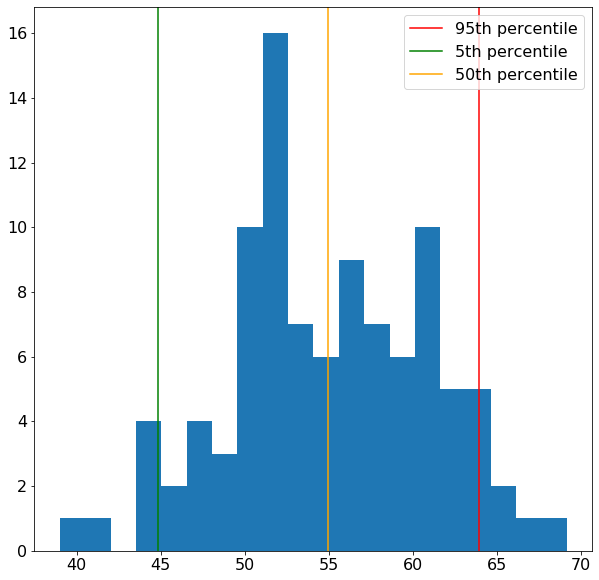

In [132]:
plt.hist(diffs, bins=20)
plt.axvline(np.percentile(diffs, 95), 0, 100, color='r', label='95th percentile')
plt.axvline(np.percentile(diffs, 5), 0, 100, color='g', label='5th percentile')
plt.axvline(np.percentile(diffs, 50), 0, 100, color='orange', label='50th percentile')
plt.legend()
plt.show()

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


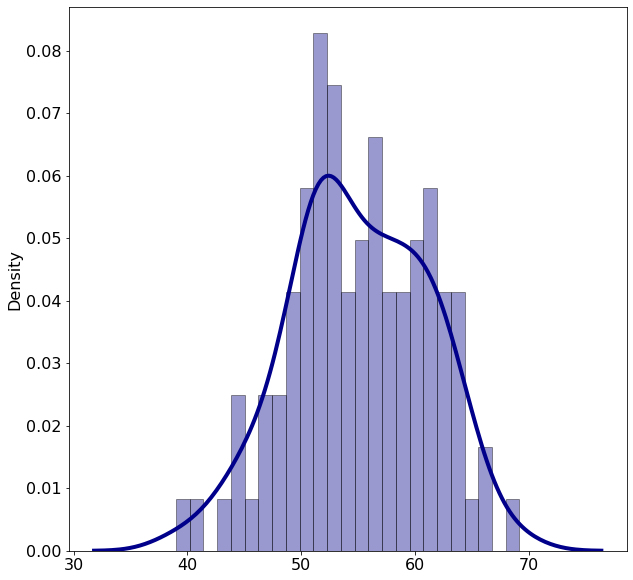

In [133]:
sns.distplot(diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

## Train catboost regressor

In [114]:
catboost_reg = CatBoostRegressor()
grid = {
    'learning_rate': [0.001, 0.01, 0.1, 1.],
    'depth':range(1, 9),
}
grid_search_results = catboost_reg.grid_search(grid, X_train, y_train, cv=5, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 320.3447372
bestIteration = 999


bestTest = 243.7748316
bestIteration = 999


bestTest = 85.32215873
bestIteration = 999


bestTest = 96.76201797
bestIteration = 995


bestTest = 309.9039201
bestIteration = 999


bestTest = 198.5336024
bestIteration = 999


bestTest = 76.56023337
bestIteration = 998


bestTest = 134.3889883
bestIteration = 230


bestTest = 301.2924413
bestIteration = 999


bestTest = 171.1623575
bestIteration = 999


bestTest = 77.12900954
bestIteration = 998


bestTest = 143.7939559
bestIteration = 74


bestTest = 295.1883988
bestIteration = 999


bestTest = 157.375407
bestIteration = 999


bestTest = 91.50006411
bestIteration = 999


bestTest = 167.7654047
bestIteration = 48


bestTest = 291.1641083
bestIteration = 999


bestTest = 153.066026
bestIteration = 999


bestTest = 102.6917937
bestIteration = 989


bestTest = 181.1011664
bestIteration = 43


bestTest = 289.6701339
bestIteration = 999


bestTest = 155.6026882
bestIteration = 999


bestTest = 120

KeyboardInterrupt: 

In [117]:
catboost_reg = CatBoostRegressor(iterations=40000, max_depth=2,
                                 learning_rate=0.1, use_best_model=True, verbose=False)
                                 # od_type='IncToDec', od_pval=0.05)
catboost_reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)
print_results(catboost_reg, X_train, X_val, X_test, y_train, y_val, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train scores:
R2: 0.9999999999494873
RMSE: 0.0023038182929638073
Val scores:
R2: 0.9598653687095169
RMSE: 62.95983399617808
Test scores:
R2: 0.9563082401683157
RMSE: 63.53630743155653


## Extract Catboost monomials

In [122]:
def transform_X_catboost(X, monomials):
    X_out = np.ones((X.shape[0], len(monomials)), dtype=np.bool)
    for i, x in enumerate(tqdm(X)):
        for j, monomial in enumerate(monomials):
            for split in monomial.splits:
                X_out[i, j] = X_out[i, j] and np.less_equal(split.border, x[split.feature_idx])
    return X_out

In [123]:
catboost_monomials = monoforest.to_polynom(catboost_reg)
X_train_catboost = transform_X_catboost(X_train, catboost_monomials)
X_val_catboost = transform_X_catboost(X_val, catboost_monomials)
X_test_catboost = transform_X_catboost(X_test, catboost_monomials)

In [124]:
print(X_train_monomial.shape, X_train_catboost.shape)

(1200, 13750) (1200, 21118)


In [125]:
select_lasso_lambda(X_train_catboost, X_val_catboost, y_train, y_val, decay=0.5)

New best score: lambda=1000, n_iter=1, rmse=314.3012220847673


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3130453.8243122995, tolerance: 12608.890687949712
  positive)


New best score: lambda=31.25, n_iter=1, rmse=266.6853895855039


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15715198.842793338, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36972.062617093325, tolerance: 12608.890687949712
  positive)


New best score: lambda=15.625, n_iter=1, rmse=188.58925113562262


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26673485.520646024, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334298.371100042, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208545.25167173892, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

New best score: lambda=7.8125, n_iter=51, rmse=150.5570922504321


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28376959.384834163, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 687393.0693814037, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299926.527780748, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

New best score: lambda=3.90625, n_iter=151, rmse=113.64374456083672


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22735894.81199938, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 991436.38397625, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 445507.5381725915, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

New best score: lambda=1.953125, n_iter=51, rmse=87.977790935391
Iter 51(lambda=0.9765625), best: lambda=1.953125, n_iter=51, rmse=87.977790935391


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17277611.533075422, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1041831.922716158, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 633885.0298256353, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

New best score: lambda=0.9765625, n_iter=51, rmse=70.40446885279323


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12657508.921848826, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1114480.305325799, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 643586.0945602218, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

New best score: lambda=0.48828125, n_iter=51, rmse=60.889557164055965


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8709572.75738764, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1422634.646483438, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 996733.2803932435, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69405.4454311906, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60458.87581604731, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51615.6584450074, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

New best score: lambda=0.244140625, n_iter=101, rmse=55.42188274007715


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5708394.605445957, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1182585.5235528646, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 799688.8571881342, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49995.019774577624, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48999.625432710716, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48373.08217243425, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

New best score: lambda=0.1220703125, n_iter=251, rmse=51.77406733886826


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3535524.481103148, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 838271.6133209694, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 616990.8988835212, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63458.39949309251, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61251.76641106436, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57935.86668329614, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

New best score: lambda=0.06103515625, n_iter=451, rmse=49.29181356841816


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2070842.4667850528, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 584724.9185404368, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 429652.1944670919, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90692.51440587982, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86809.83869103911, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82319.92680044903, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

New best score: lambda=0.030517578125, n_iter=901, rmse=48.54925216204546


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1166778.3205951594, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 385209.5667536806, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 296265.33755583176, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79995.72273104585, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76593.4446237378, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76751.89393575441, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

New best score: lambda=0.0152587890625, n_iter=1801, rmse=48.178265571475414


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 644834.1380291783, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253941.74207845255, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194342.32287177237, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59307.121308588605, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59758.659664695035, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58530.0405988518, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51572.009429941914, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50204.34744124523, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49537.177152995384, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51503.37699212635, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48953.28362998622, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46798.66011303708, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25832.210253684792, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25454.37429496471, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25155.3452176009, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

Iter 1951(lambda=0.00095367431640625), best: lambda=0.0152587890625, n_iter=1801, rmse=48.178265571475414


/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126694.87159971954, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60007.44949401289, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50909.869081724704, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19517.62542055524, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19238.282860296, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19014.52542438743, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15335.5125100672, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15003.490380749176, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14713.787325830392, tolerance: 12608.890687949712
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

(0.0152587890625, 1801, 48.178265571475414)

In [127]:
catboost_lasso_params = {'alpha' : 0.0152587890625, 'max_iter' : 1801}

In [129]:
n = X_test.shape[0]
catboost_diffs = []
for _ in tqdm(range(100)):
    ids = np.random.choice(np.arange(n), n, replace=True)
    lasso = Lasso(**catboost_lasso_params).fit(X_train_catboost[ids], y_train[ids])
    reg = GradientBoostingRegressor(**best_params).fit(X_train[ids], y_train[ids])
    catboost_diffs.append(reg.score(X_test, y_test) - lasso.score(X_test_catboost, y_test))

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9189.600127395648, tolerance: 3786.5490071474255
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11285.148167427415, tolerance: 4020.573836570538
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11585.484771821593, tolerance: 4318.203940333756
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13261.266664497707, tolerance: 4597.99195239321
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10412.8539468992, tolerance: 4131.231113246399
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10203.324509241424, tolerance: 4396.818885655439
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not conv

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11282.921140957938, tolerance: 4295.752666876742
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9548.01094606867, tolerance: 3700.84613790371
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10636.050124573783, tolerance: 4151.313368221964
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not conv

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13365.869190224117, tolerance: 4119.709829993467
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9802.31037232833, tolerance: 4159.602421294099
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10285.551655913907, tolerance: 4155.383128308102
  positive)
/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/home/itukh/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


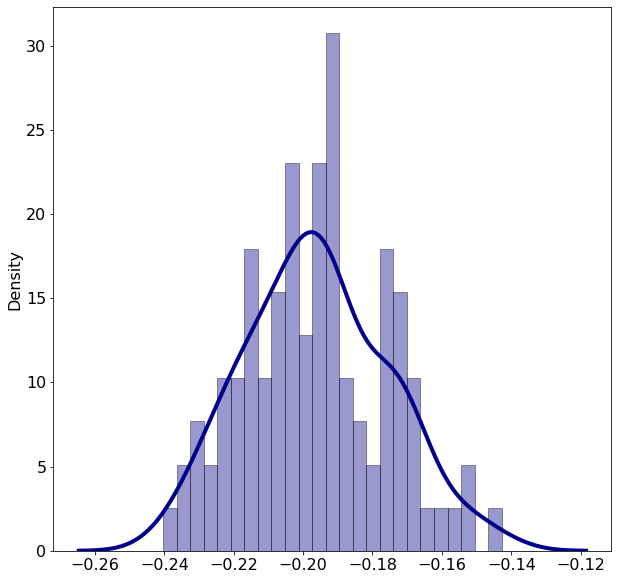

In [130]:
sns.distplot(catboost_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})